In [163]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from deap import base, creator, tools, algorithms
from tqdm import tqdm

import sys

sys.path.append("../")

from src.errors import sammon_error

# def sammon_error(X, selected_features):
#     selected_features = np.array(selected_features, dtype=bool)
#     X_low = X[:, selected_features]
#     D_orig = squareform(pdist(X, metric='euclidean'))
#     D_low = squareform(pdist(X_low, metric='euclidean'))
#     D_orig[D_orig == 0] = np.finfo(float).eps
#     sammon_err = np.sum(((D_orig - D_low) ** 2) / D_orig) / np.sum(D_orig)
#     return sammon_err,



# Example usage:
# best_solution = ga_feature_selection(data_train)
# test_error = evaluate_solution(data_test, best_solution)
# print("Test Sammon Error:", test_error)

In [164]:
def init_fixed_k(n_features, k):
    """Generate a binary mask with exactly k selected features"""
    mask = [0] * n_features
    selected_indices = random.sample(range(n_features), k)
    for i in selected_indices:
        mask[i] = 1
    return mask


def cx_fixed_k(ind1, ind2, k):
    """Perform crossover while maintaining exactly k selected features"""
    ones1 = {i for i, bit in enumerate(ind1) if bit == 1}
    ones2 = {i for i, bit in enumerate(ind2) if bit == 1}

    # Swap a random subset of 1s between parents
    swap_size = random.randint(1, min(len(ones1), len(ones2)))
    swap1 = set(random.sample(list(ones1), swap_size))
    swap2 = set(random.sample(list(ones2), swap_size))

    ones1 = (ones1 - swap1) | swap2
    ones2 = (ones2 - swap2) | swap1

    # Ensure the number of selected features (1s) is exactly k
    if len(ones1) > k:
        excess = len(ones1) - k
        ones1 = set(random.sample(ones1, k))
    elif len(ones1) < k:
        # Add zeros from the unselected set
        zeros1 = set(i for i in range(len(ind1)) if i not in ones1)
        add_zeros = random.sample(list(zeros1), k - len(ones1))
        ones1.update(add_zeros)

    if len(ones2) > k:
        excess = len(ones2) - k
        ones2 = set(random.sample(ones2, k))
    elif len(ones2) < k:
        # Add zeros from the unselected set
        zeros2 = set(i for i in range(len(ind2)) if i not in ones2)
        add_zeros = random.sample(list(zeros2), k - len(ones2))
        ones2.update(add_zeros)

    # Convert to binary masks
    new_ind1 = [1 if i in ones1 else 0 for i in range(len(ind1))]
    new_ind2 = [1 if i in ones2 else 0 for i in range(len(ind2))]

    ind1[:] = new_ind1
    ind2[:] = new_ind2

    # print(np.sum(ind1), k)
    assert np.sum(ind1) == k
    assert np.sum(ind2) == k

    return ind1, ind2


# def mut_fixed_k(individual, k):
#     """ Mutation operator that keeps exactly k selected features """
#     ones = [i for i, bit in enumerate(individual) if bit == 1]
#     zeros = [i for i, bit in enumerate(individual) if bit == 0]

#     if ones and zeros:
#         # Swap one selected and one unselected feature
#         swap_in = random.choice(zeros)
#         swap_out = random.choice(ones)
#         individual[swap_in] = 1
#         individual[swap_out] = 0

#     print(np.sum(individual), k)
#     assert np.sum(individual) == k
#     return individual,


def mut_fixed_k(individual, k):
    """Mutation operator that keeps exactly k selected features"""
    ones = [i for i, bit in enumerate(individual) if bit == 1]
    zeros = [i for i, bit in enumerate(individual) if bit == 0]

    if ones and zeros:
        # Swap one selected and one unselected feature
        swap_in = random.choice(zeros)
        swap_out = random.choice(ones)
        individual[swap_in] = 1
        individual[swap_out] = 0

    # Ensure that exactly k features are selected
    ones = [i for i, bit in enumerate(individual) if bit == 1]
    if len(ones) != k:
        # If the number of selected features isn't correct, adjust
        if len(ones) > k:
            # Remove excess 1's by setting them to 0
            for i in random.sample(ones, len(ones) - k):
                individual[i] = 0
        elif len(ones) < k:
            # Add more 1's by setting 0's to 1
            zeros = [i for i, bit in enumerate(individual) if bit == 0]
            for i in random.sample(zeros, k - len(ones)):
                individual[i] = 1

    # print(np.sum(individual), k)
    assert np.sum(individual) == k  # Ensure that we have exactly k selected features

    return (individual,)

In [165]:
def evaluate(individual, X):
    return (sammon_error(X, individual),)

def ga_feature_selection(X_train, target_k, pop_size=50, n_gen=100, cx_prob=0.7, mut_prob=0.2):
    n_features = X_train.shape[1]
   
   # Check if the classes already exist before creating them
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    # toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: init_fixed_k(n_features, target_k))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # toolbox.register("mate", tools.cxUniform, indpb=0.5)
    toolbox.register("mate", cx_fixed_k, k=target_k)
    # toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("mutate", mut_fixed_k, k=target_k)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate, X=X_train)
    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=cx_prob, mutpb=mut_prob, ngen=n_gen, stats=stats, halloffame=hof, verbose=False)
    return hof[0]

def evaluate_solution(X_test, selected_features):
    return sammon_error(X_test, selected_features)

In [166]:
def get_data_frames(train_path, test_path):
    data_train = pd.read_csv(train_path, sep=",")
    data_test = pd.read_csv(test_path, sep=",")

    return data_train, data_test


def get_data_train_test(data_train, data_test):
    X_train = data_train.drop(columns=["repository"], inplace=False)
    X_train = X_train.to_numpy()

    X_test = data_test.drop(columns=["repository"], inplace=False)
    X_test = X_test.to_numpy()

    return X_train, X_test

In [167]:
train_path_class = "../data/data_class_train.csv"
test_path_class = "../data/data_class.csv"
train_path_method = "../data/data_method_train.csv"
test_path_method = "../data/data_method.csv"

In [168]:
data_train_method, data_test_method = get_data_frames(train_path_method, test_path_method)
X_train_method, X_test_method = get_data_train_test(data_train_method, data_test_method)
state_space_method = X_train_method.shape[1]
action_space_method = X_train_method.shape[1]

data_train_class, data_test_class = get_data_frames(train_path_class, test_path_class)
X_train_class, X_test_class = get_data_train_test(data_train_class, data_test_class)
state_space_class = X_train_class.shape[1]
action_space_class = X_train_class.shape[1]

In [169]:
def evaluate_ga(X_train, X_test, target_k):
    selected_features = ga_feature_selection(X_train=X_train, target_k=target_k)
    return sammon_error(X_test, selected_features=selected_features)

In [170]:
# class
all_errors_class = []
for _ in tqdm(range(10), desc="Outer loop progress"):
    errors_class = []
    for i in range(1, X_train_class.shape[1]):
        errors_class.append(evaluate_ga(X_train_class, X_test_class, target_k=i))
    all_errors_class.append(errors_class)

Outer loop progress:   0%|          | 0/10 [00:00<?, ?it/s]/var/folders/b5/d68y3kns4w1c2sblc9gs2j2h0000gp/T/ipykernel_73099/1728860999.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  add_zeros = random.sample(zeros1, k - len(ones1))
/var/folders/b5/d68y3kns4w1c2sblc9gs2j2h0000gp/T/ipykernel_73099/1728860999.py:39: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  add_zeros = random.sample(zeros2, k - len(ones2))
Outer loop progress:  10%|█         | 1/10 [00:12<01:50, 12.25s/it]


KeyboardInterrupt: 

In [ ]:
min_errors = np.min(all_errors_class, axis=0)
max_errors = np.max(all_errors_class, axis=0)
avg_errors = np.mean(all_errors_class, axis=0)
min_errors, max_errors, avg_errors

ValueError: zero-size array to reduction operation minimum which has no identity

In [133]:
df_ga_class = pd.DataFrame({
    "number_of_features": 1 + np.arange(X_test_class.shape[1]-1),
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_ga_class

,number_of_features,min_error,max_error,avg_error
0,1,2.571245e-01,2.571245e-01,2.571245e-01
1,2,9.754496e-02,9.754496e-02,9.754496e-02
2,3,4.327469e-02,4.327469e-02,4.327469e-02
3,4,1.850169e-02,1.850169e-02,1.850169e-02
4,5,7.790031e-03,7.790031e-03,7.790031e-03
5,6,3.677137e-03,3.677137e-03,3.677137e-03
6,7,6.633146e-04,3.169942e-03,1.467248e-03
7,8,2.659712e-04,6.633146e-04,4.033915e-04
8,9,9.463050e-05,2.659712e-04,2.082581e-04
9,10,3.241470e-05,9.463050e-05,7.181804e-05


In [134]:
df_ga_class.to_csv("../data/results/GA_class.csv", index=False)

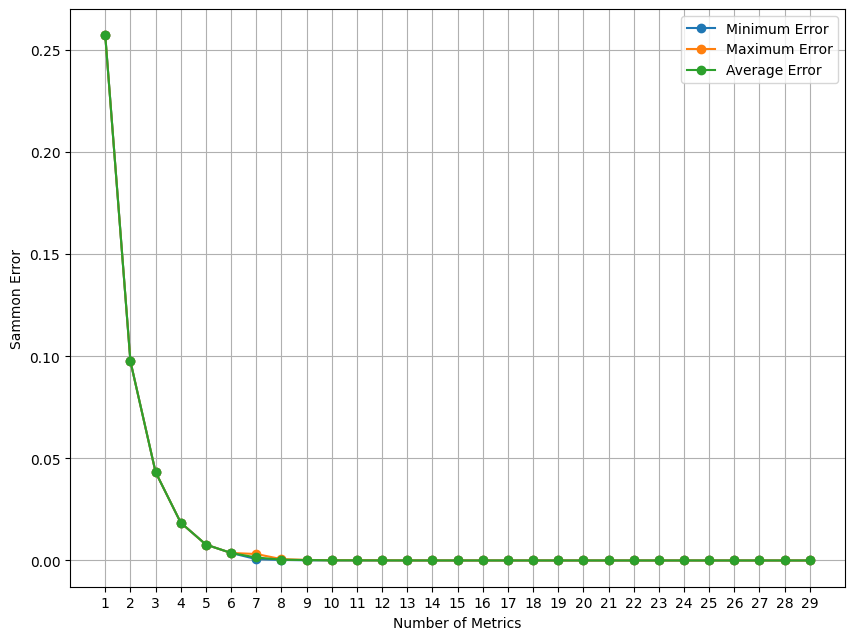

In [ ]:
# Plot
plt.figure(figsize=(10, 7.5))
_x = 1 + np.arange(X_test_class.shape[1]-1)
plt.plot(_x, min_errors, marker='o', label='Minimum Error')
plt.plot(_x, max_errors, marker='o', label='Maximum Error')
plt.plot(_x, avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(_x)  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()

In [136]:
# method
all_errors_method = []
for _ in tqdm(range(10), desc="Outer loop progress"):
    errors_method = []
    for i in range(1, X_train_method.shape[1]):
        errors_method.append(evaluate_ga(X_train_method, X_test_method, target_k=i))
    all_errors_method.append(errors_method)

Outer loop progress: 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


In [137]:
min_errors = np.min(all_errors_method, axis=0)
max_errors = np.max(all_errors_method, axis=0)
avg_errors = np.mean(all_errors_method, axis=0)
min_errors, max_errors, avg_errors

(array([1.18138867e-02, 3.32887243e-03, 2.18314492e-03, 1.51914040e-03,
        5.28654261e-04, 3.44936824e-04, 2.46312426e-04, 1.54955853e-04,
        1.00367388e-04, 3.56567531e-05, 1.53853721e-05, 9.69927210e-06,
        6.06524832e-06, 4.94482377e-06, 2.05304730e-06, 1.70978111e-06,
        2.82512266e-07, 7.21470572e-08, 6.92908529e-08, 9.43547399e-11,
        4.17033099e-18, 1.37869433e-20, 1.37869433e-20, 1.37869433e-20,
        1.37869433e-20]),
 array([1.18138867e-02, 3.32887243e-03, 2.18314492e-03, 1.51914040e-03,
        5.28654261e-04, 3.44936824e-04, 2.47033657e-04, 1.84300095e-04,
        1.01646020e-04, 1.00670829e-04, 6.25072273e-05, 5.65873711e-05,
        1.09843485e-05, 8.79111324e-06, 7.13307098e-06, 3.79788659e-06,
        1.77062881e-06, 1.67857983e-06, 5.09306406e-07, 7.21468241e-08,
        9.43547399e-11, 9.43296131e-11, 1.37869433e-20, 1.37869433e-20,
        1.37869433e-20]),
 array([1.18138867e-02, 3.32887243e-03, 2.18314492e-03, 1.51914040e-03,
        5.28

In [138]:
df_ga_method = pd.DataFrame({
    "number_of_features": 1 + np.arange(X_test_method.shape[1]-1),
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_ga_method

,number_of_features,min_error,max_error,avg_error
0,1,1.181389e-02,1.181389e-02,1.181389e-02
1,2,3.328872e-03,3.328872e-03,3.328872e-03
2,3,2.183145e-03,2.183145e-03,2.183145e-03
3,4,1.519140e-03,1.519140e-03,1.519140e-03
4,5,5.286543e-04,5.286543e-04,5.286543e-04
5,6,3.449368e-04,3.449368e-04,3.449368e-04
6,7,2.463124e-04,2.470337e-04,2.469615e-04
7,8,1.549559e-04,1.843001e-04,1.796725e-04
8,9,1.003674e-04,1.016460e-04,1.006711e-04
9,10,3.565675e-05,1.006708e-04,6.624967e-05


In [139]:
df_ga_method.to_csv("../data/results/GA_method.csv", index=False)

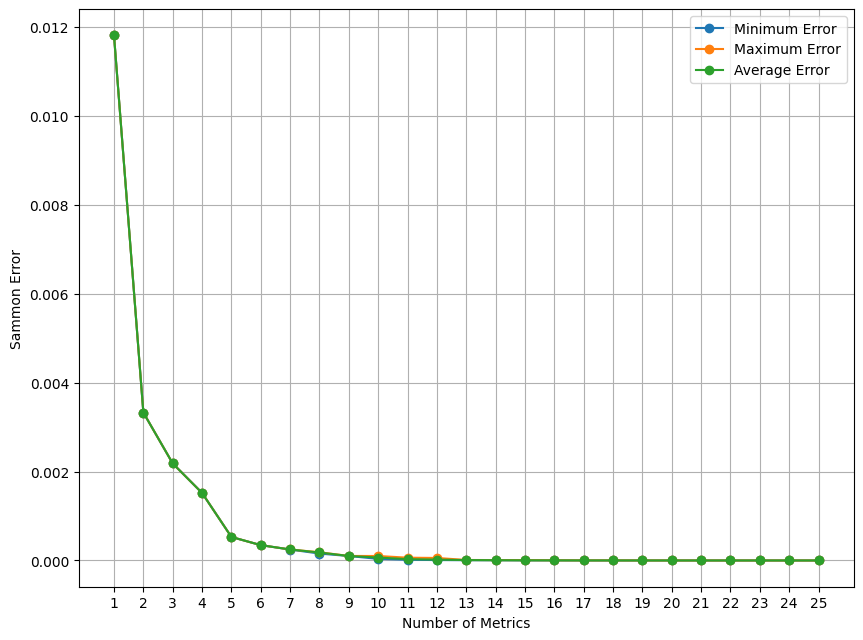

In [140]:
# Plot
_x = 1 + np.arange(X_test_method.shape[1]-1)
plt.figure(figsize=(10, 7.5))
plt.plot(_x, min_errors, marker='o', label='Minimum Error')
plt.plot(_x, max_errors, marker='o', label='Maximum Error')
plt.plot(_x, avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(_x)  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()